In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/stress-strain_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        traj = gsd.hoomd.open(exper)

        stress = []
        shear = []

        for i in range(len(traj)):

            snap = traj[i] # initial state
            # print(snap.log)
            xy = snap.configuration.box[3]
            stress_xy = snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1]
            stress.append(stress_xy)
            shear.append(xy)
        dataset = pd.DataFrame({"strain": shear, "stress": stress})
        output[sp].append(dataset)

with open(project.fn("results/aqs-stress-strain_period-1000.pkl"), "wb") as f:
    pickle.dump(output, f)

634e14bc75836df75158fb15f379d8bb


KeyboardInterrupt: 

In [6]:
with open(project.fn("results/aqs-stress-strain_period-1000.pkl"), "rb") as f:
    output = pickle.load(f)

In [7]:
for k in output.keys():
    print(k)

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.08, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.12, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='ESL')
Statepoint(max_shear=0.02, 

In [19]:
def plot_stress_strain(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.LogNorm(vmin=1e-3, vmax=4e-2)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        # temp to idx mapping using
        temps = [0.019836, 0.0019836]
        i = temps.index(k.temp)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[-40*40-1:]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[-40*40-1:]
        stress = np.array([np.mean(stress[i::40]) for i in range(41)])
        strain = np.array([np.mean(strain[i::40]) for i in range(41)])
        print(k, stress.shape, strain.shape)
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for ax in axs:
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
    fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0

Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.08, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.08, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.12, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.12, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)


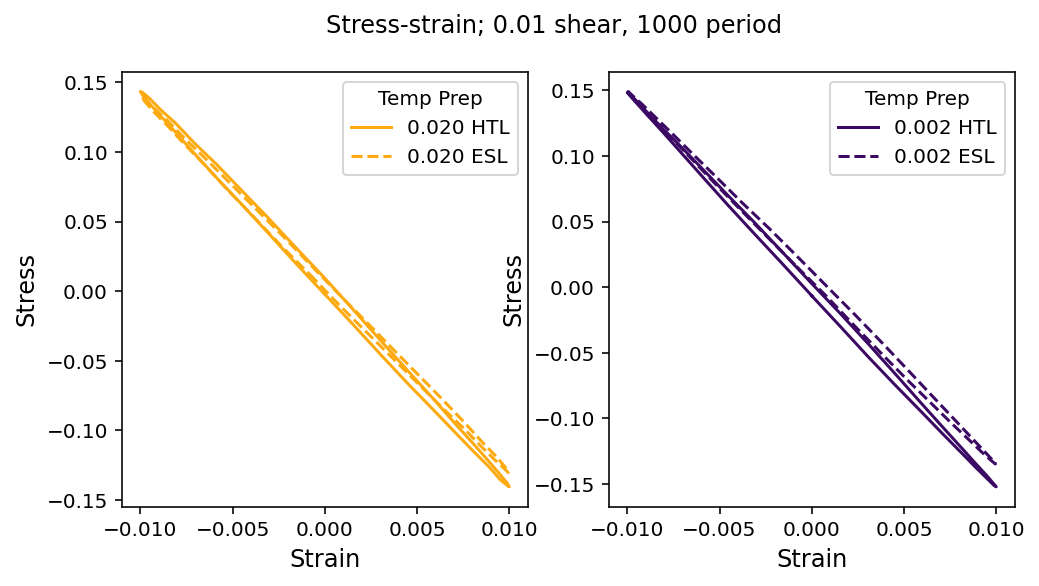

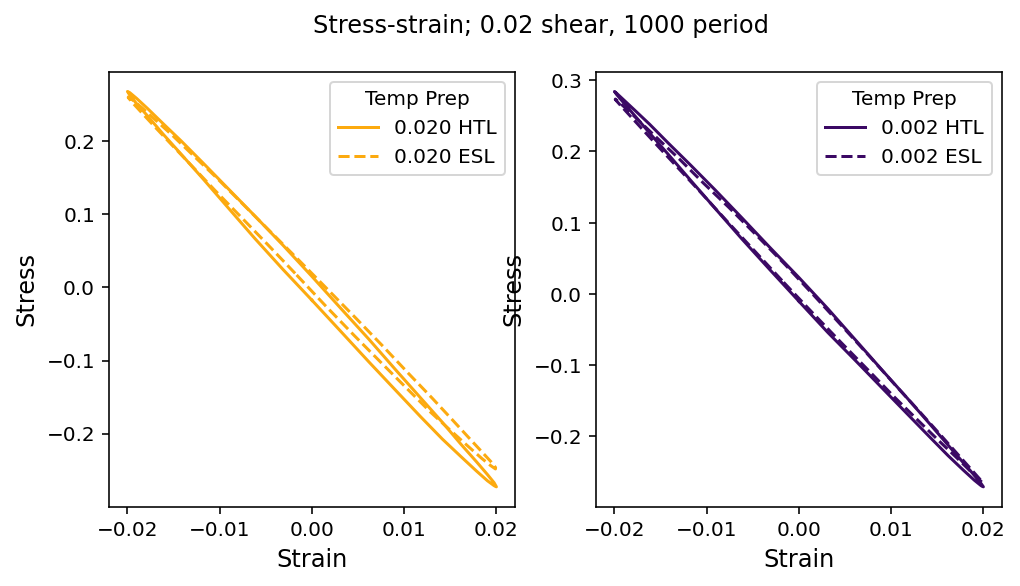

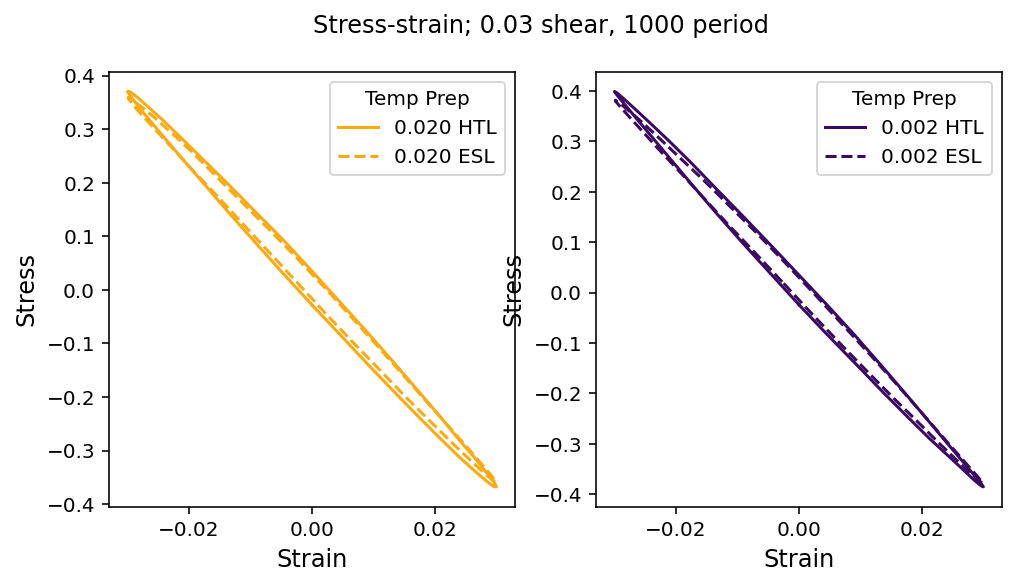

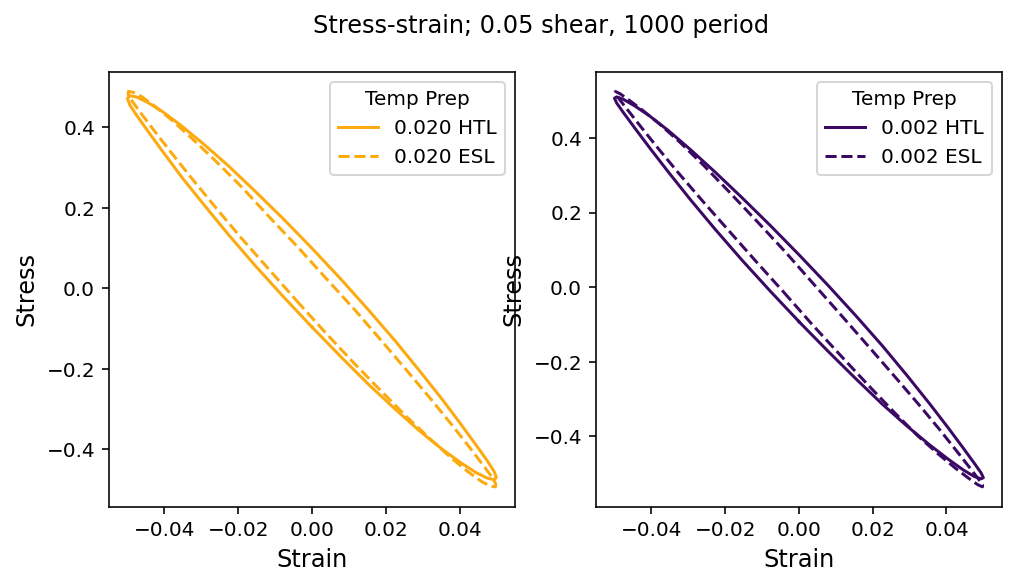

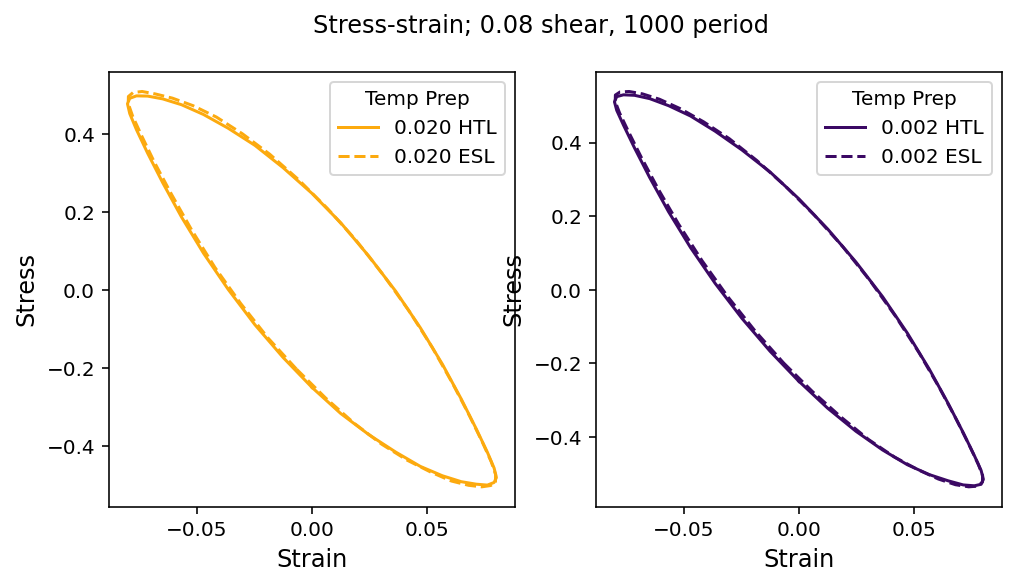

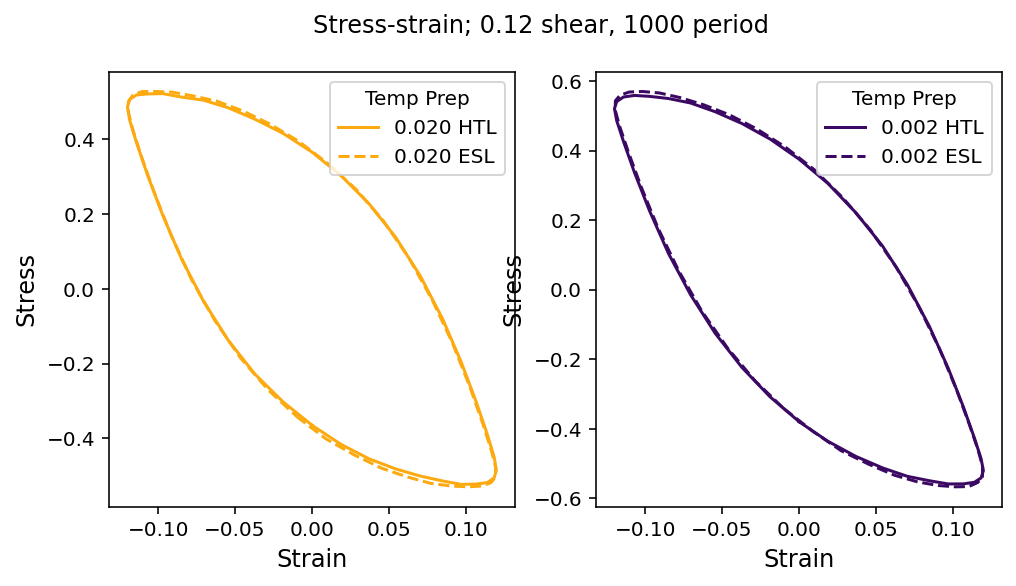

In [20]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_stress_strain(shear, legend=True)

In [17]:
def plot_stress_strain_transient(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.LogNorm(vmin=1e-3, vmax=4e-2)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = ":"

        # temp to idx mapping using
        temps = [0.019836, 0.0019836]
        i = temps.index(k.temp)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[:40*5]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[:40*5]
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for ax in axs:
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
    fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

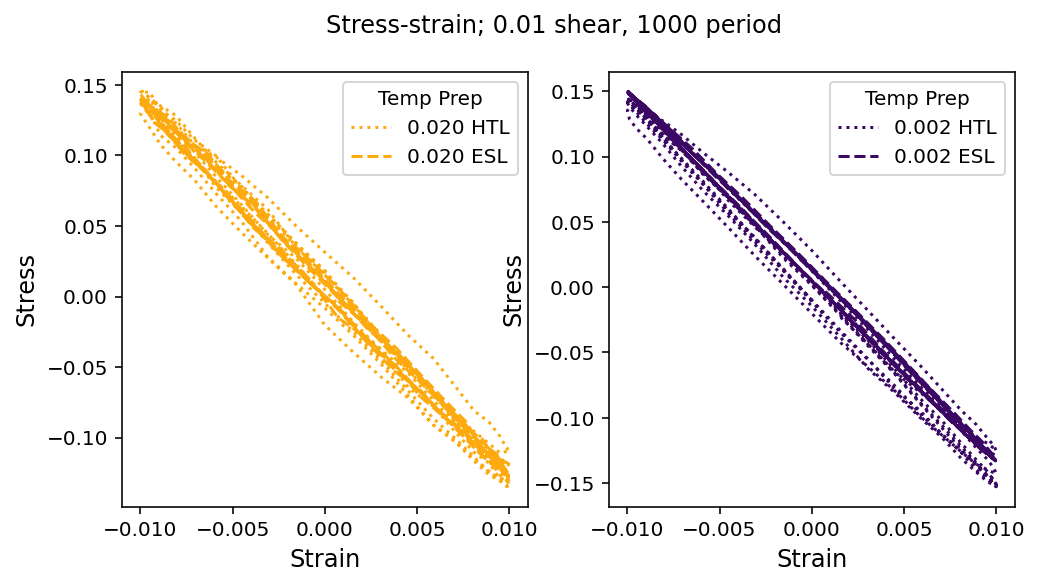

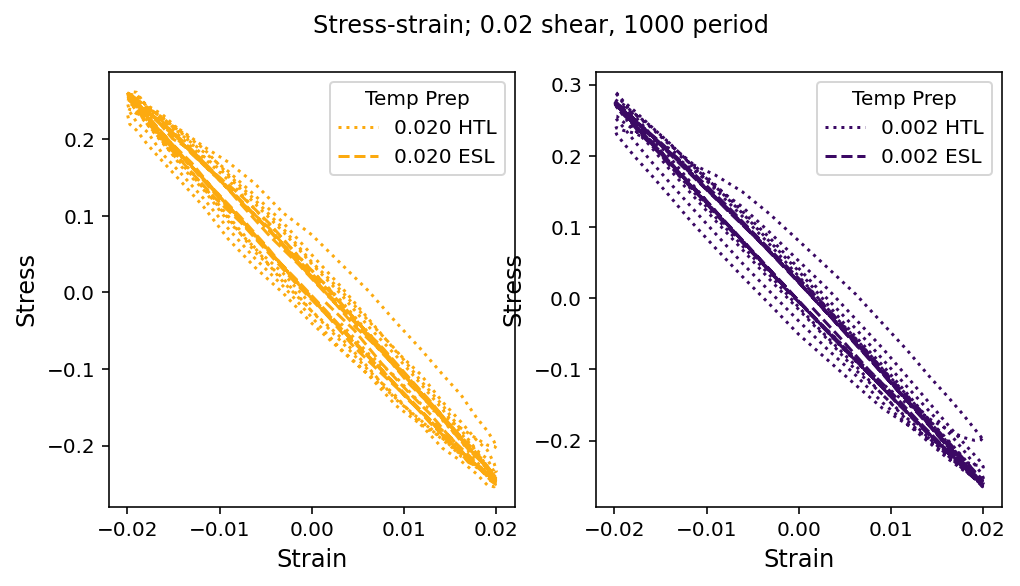

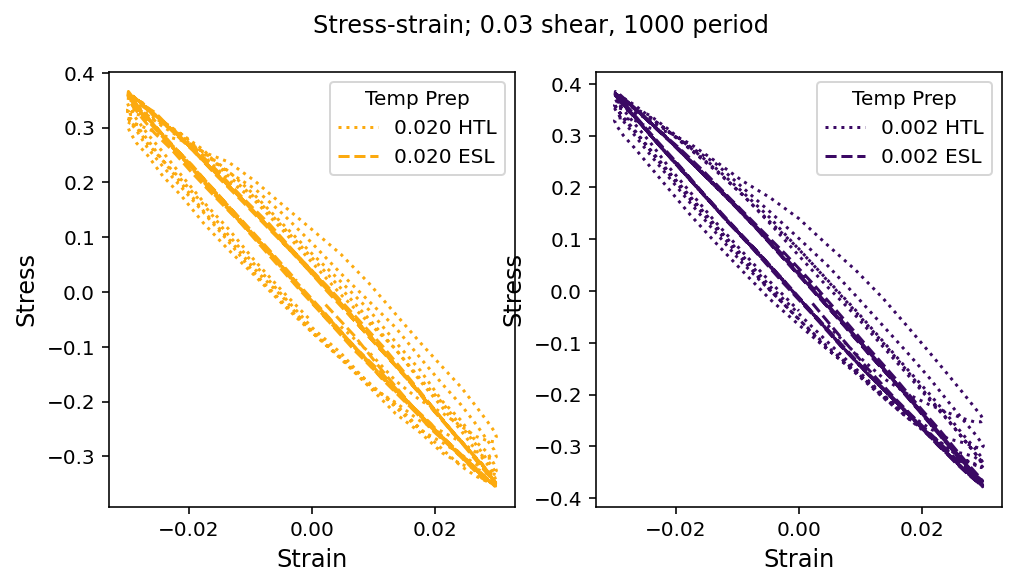

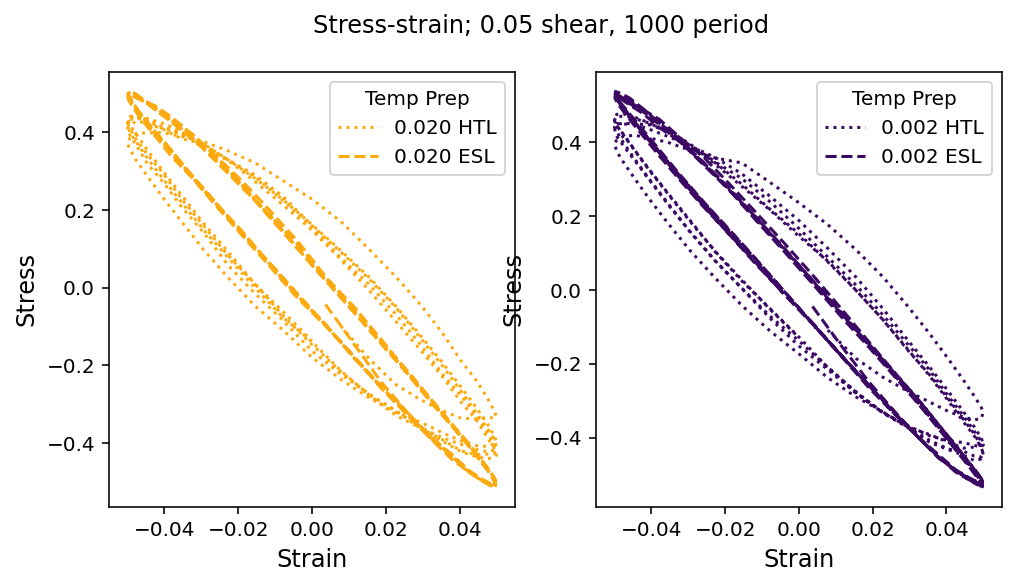

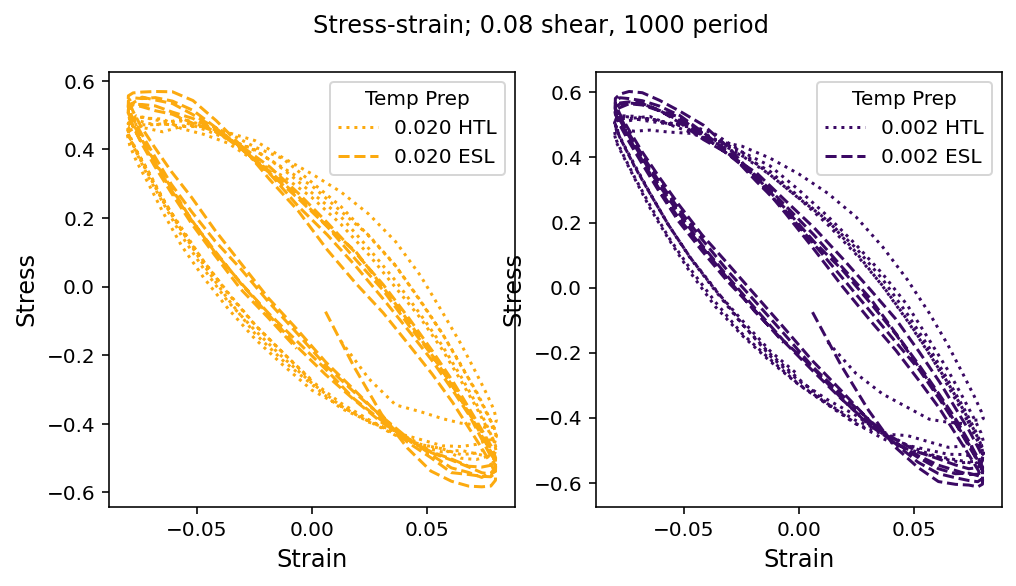

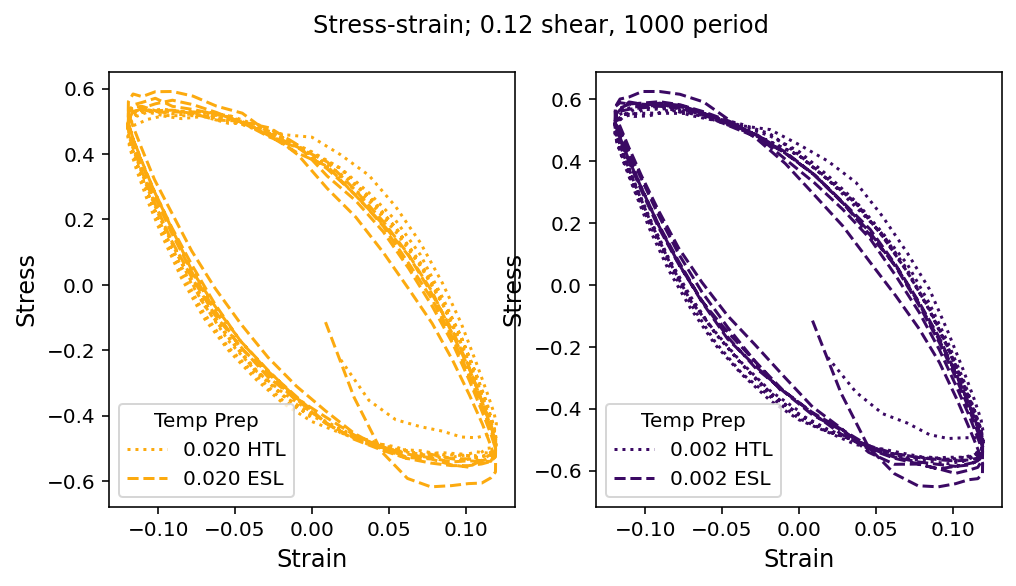

In [18]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_stress_strain_transient(shear, legend=True)

In [ ]:
def plot_tan_delta(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.LogNorm(vmin=1e-3, vmax=4e-2)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        # temp to idx mapping using
        temps = [0.019836, 0.0019836]
        i = temps.index(k.temp)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[-20*40-1:]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[-20*40-1:]
        stress = np.array([np.mean(stress[i::40]) for i in range(41)])
        strain = np.array([np.mean(strain[i::40]) for i in range(41)])
        print(k, stress.shape, strain.shape)
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for ax in axs:
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
    fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

In [12]:
def plot_stress_strain_late(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.LogNorm(vmin=1e-3, vmax=4e-2)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        # temp to idx mapping using
        temps = [0.019836, 0.0019836]
        i = temps.index(k.temp)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[-20*40-1:]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[-20*40-1:]
        stress = np.array([np.mean(stress[i::40]) for i in range(41)])
        strain = np.array([np.mean(strain[i::40]) for i in range(41)])
        print(k, stress.shape, strain.shape)
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for ax in axs:
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
    fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='ESL') (41,) (41,)
Statepoint(max_shear=0

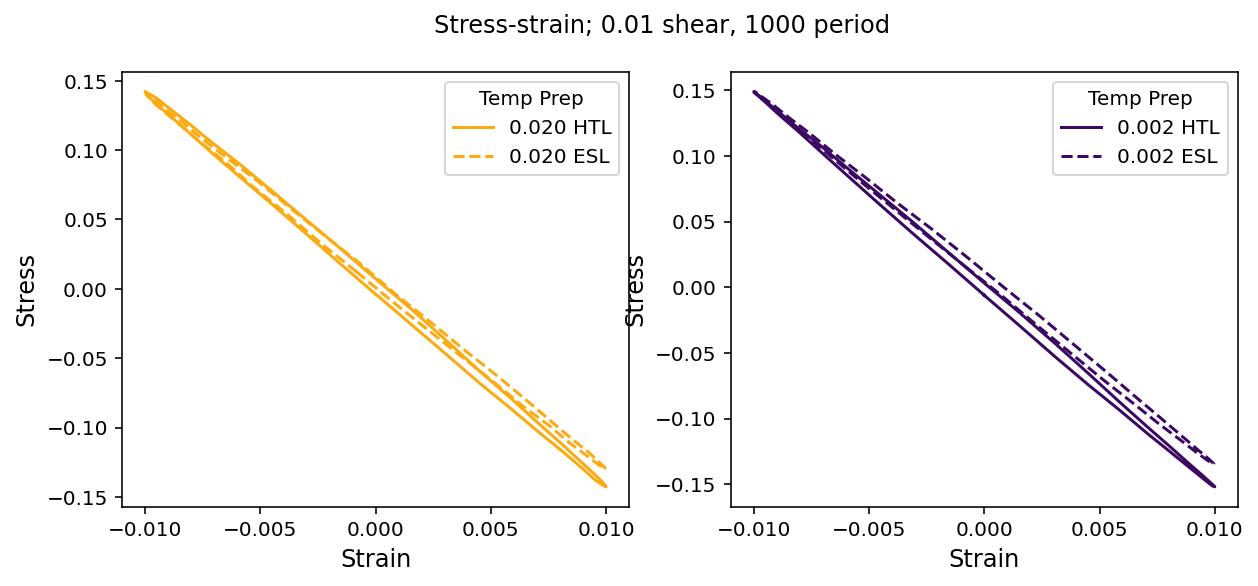

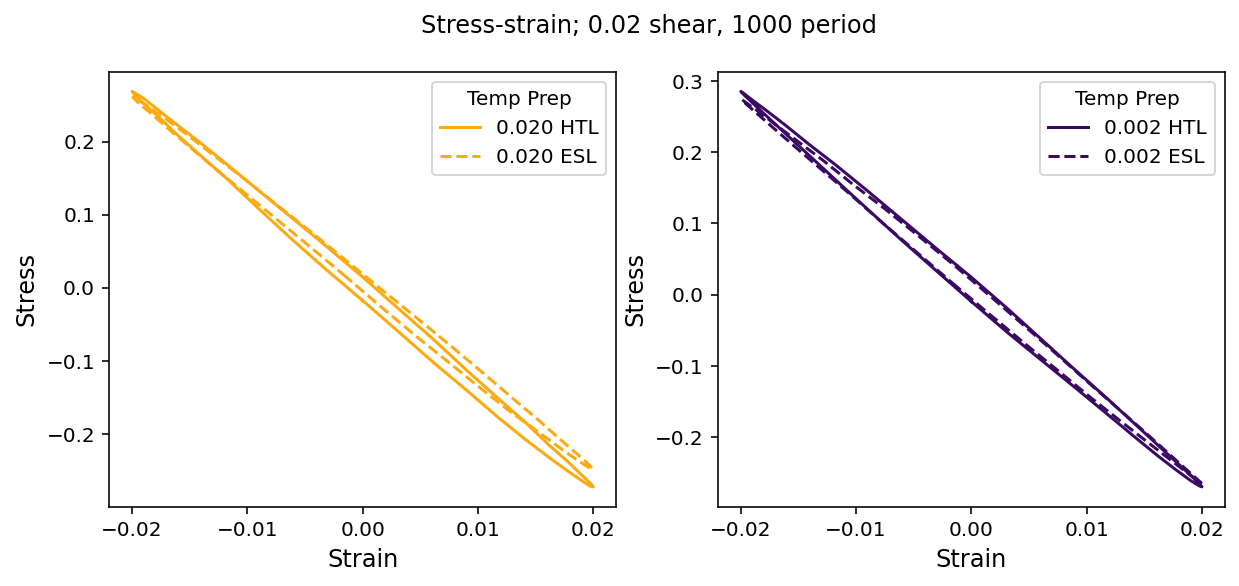

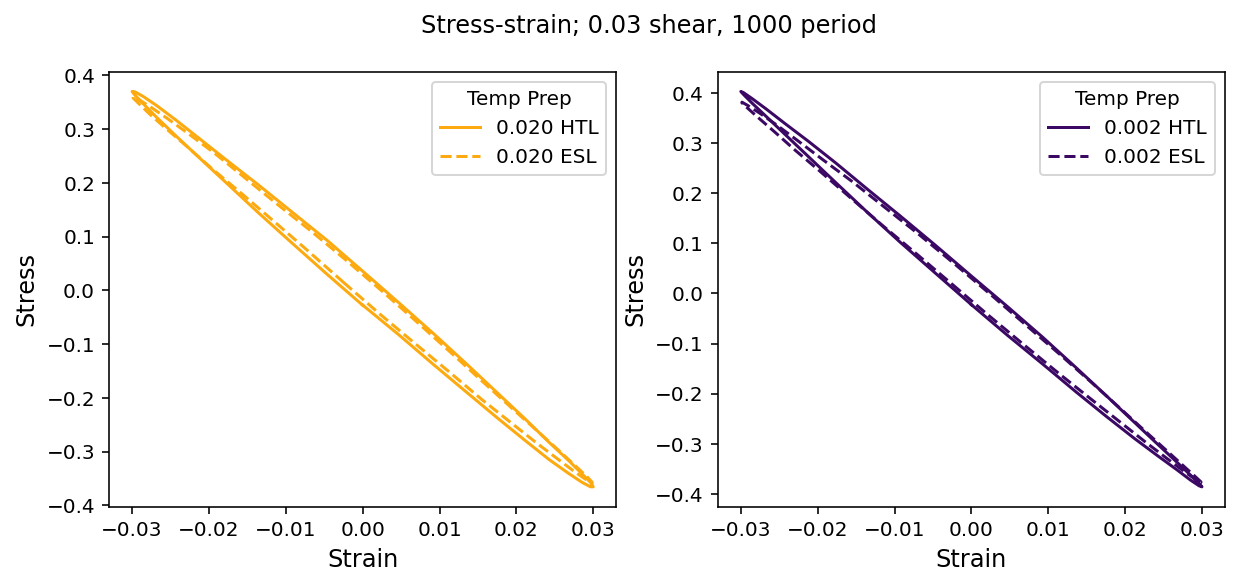

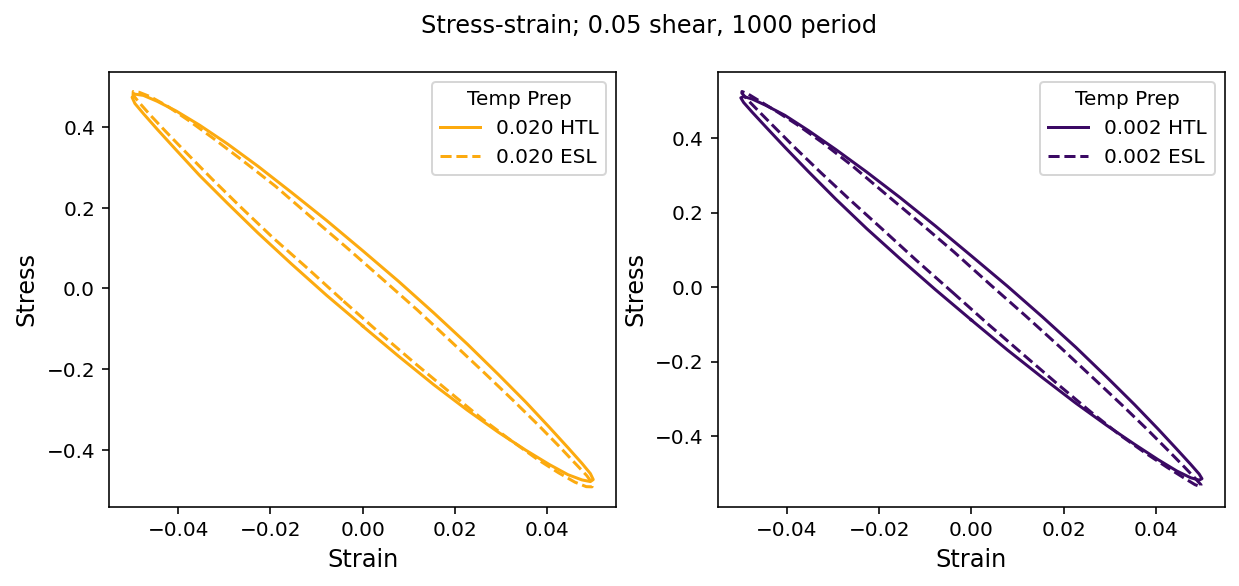

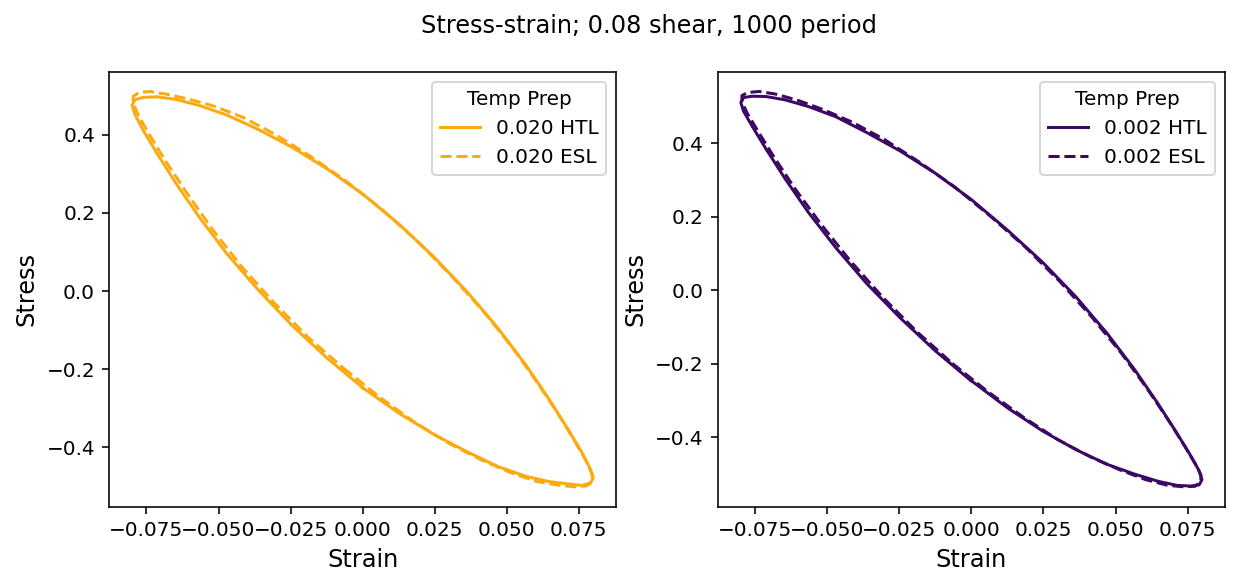

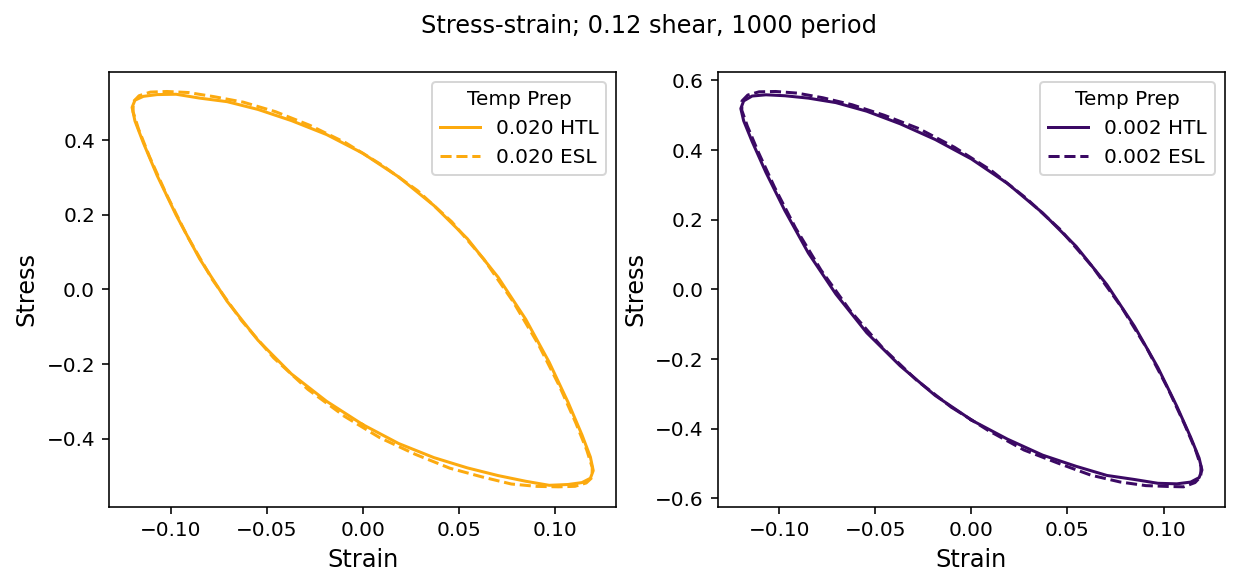

In [13]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_stress_strain_late(shear, legend=True)

In [46]:
def plot_pres(temp=0.005, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.LogNorm(vmin=1e-3, vmax=4e-2)

    shears = [0.02, 0.05, 0.12]

    for k, v in output.items():
        print(k)
        if k.temp == 0.019836:
            print("no!")
            continue
        print("yes!")
        print(k.temp, k.temp < temp)
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        # temp to idx mapping using
        if k.max_shear not in shears:
            continue
        i = shears.index(k.max_shear)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[-20*40-1:]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[-20*40-1:]
        stress = np.array([np.mean(stress[i::40]) for i in range(41)])
        strain = np.array([np.mean(strain[i::40]) for i in range(41)])
        print(k, stress.shape, strain.shape)
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for shear, ax in zip(shears, axs):
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
        ax.set_title(f"{shear*100}% shear")
        # ax.set_aspect('equal', adjustable='box')
    # fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL') (41,) (41,)
Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.08, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=

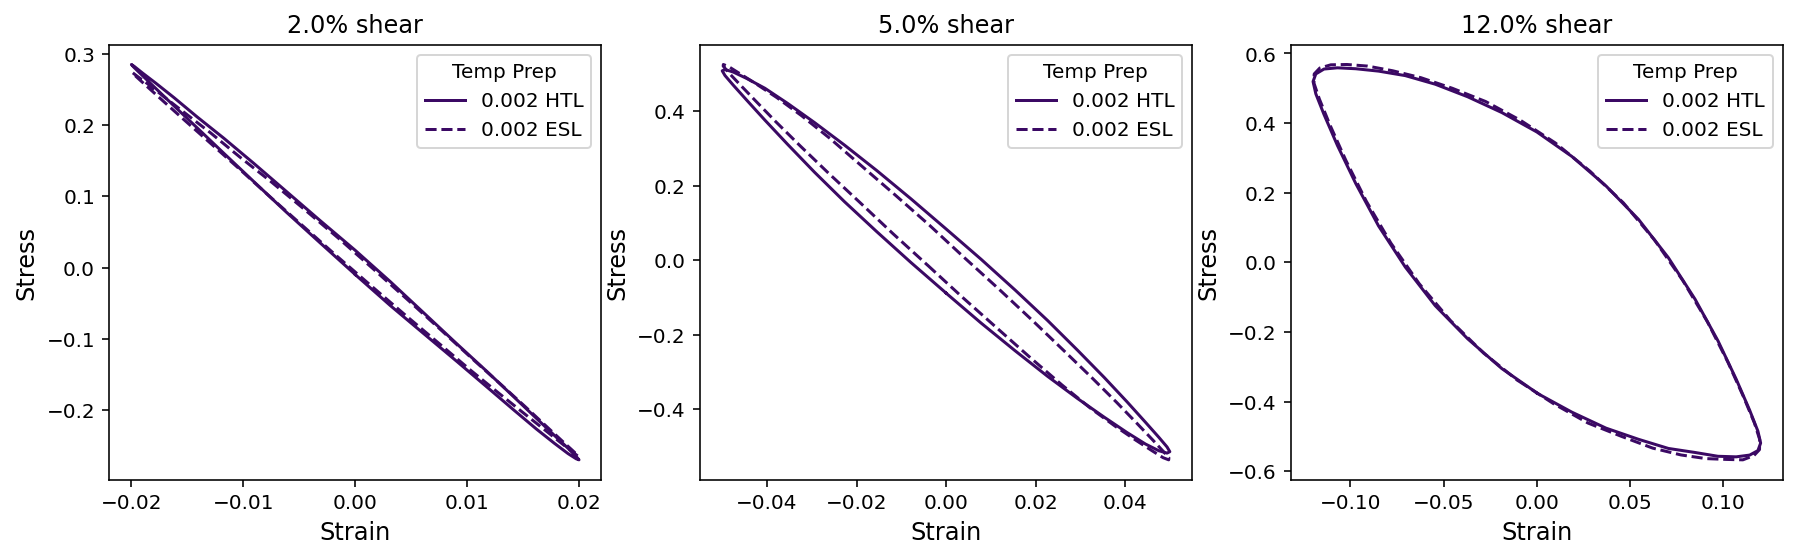

In [47]:

plot_pres(shear, legend=True)

In [50]:
def plot_pres_transient(temp, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    else:
        fig = axs.figure
    
    cmap = cm.inferno
    norm = colors.LogNorm(vmin=1e-3, vmax=4e-2)

    shears = [0.02, 0.05, 0.12]

    for k, v in output.items():
        print(k)
        if k.temp == 0.019836:
            print("no!")
            continue
        print("yes!")
        print(k.temp, k.temp < temp)
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        # temp to idx mapping using
        if k.max_shear not in shears:
            continue
        i = shears.index(k.max_shear)

        stress = np.mean([v_i["stress"].values for v_i in v], axis=0)[:40*5]
        strain = np.mean([v_i["strain"].values for v_i in v], axis=0)[:40*5]
        # frames = v[0]["frame"].values
        axs[i].plot(strain, stress, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=1)
    for shear, ax in zip(shears, axs):
        ax.set_ylabel("Stress", size="large")
        ax.set_xlabel("Strain", size="large")
        if legend:
            ax.legend(title="Temp Prep")
        ax.set_title(f"{shear*100}% shear")
    # fig.suptitle(f"Stress-strain; {shear} shear, 1000 period")

Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.08, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='HTL')
no!
Statepoint(max_shear=0.12, period=1000.0, temp=0.0019836, prep='HTL')
yes!
0.0019836 True
Statepoint(max_shear=0

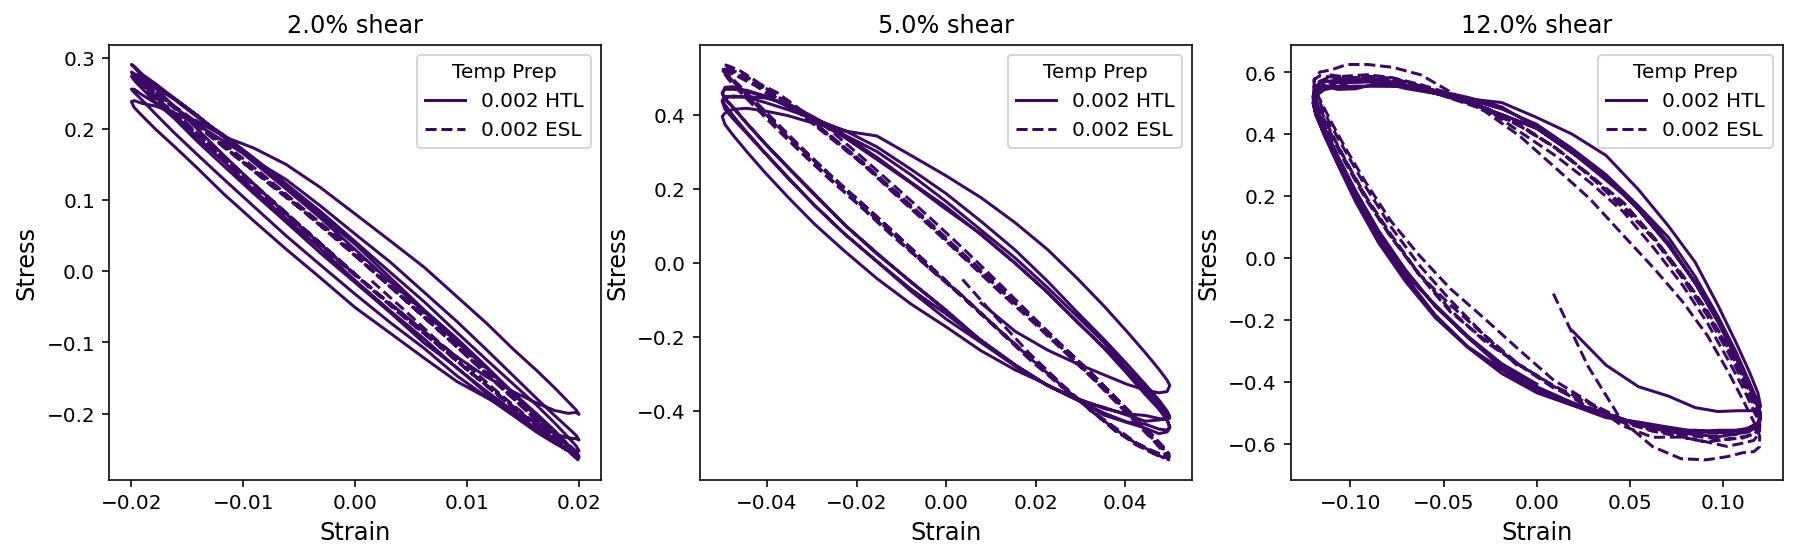

In [51]:

plot_pres_transient(shear, legend=True)